<a href="https://colab.research.google.com/github/Colsai/covid_trends_mapping/blob/main/cleaned_covid_visualizations_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Covid Trends and Predictions 
<blockquote> Scott Hirabayashi | (Sourced from NYT's Github) | 2020  </blockquote>

- Visualizations and Basic Information about trends in cases, etc.  
- Included- A Basic ML Model to Estimate Cases and Deaths  
- Focus on USA/MD/VA  
- NYT Datasets Used  


In [340]:
#Datetime To Convert Dates
from datetime import datetime

#Import Packages for Data
import pandas as pd
import numpy as np
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import statistics

In [341]:
#Seaborn/Matplotlib basic stats
sns.set(style="ticks")
plt.style.use('seaborn-white')

In [342]:
#Cases by day from beginning (US)

#USA Data will be the dataframe for national data
site = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
us_df = pd.read_csv(site)

In [343]:
#Let's look at the head of us df first
us_df.head(5)

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


## Let's look at US DF First
We will look to build a simple predictive model here

In [344]:
#One issue here is that the date data is currently string. We need to make it datetime.
type(us_df['date'][0])

str

In [345]:
#Small function to convert it back to datetime
def chg_date(input_list):
    new_dates = []

    for i in input_list:
        date_output = datetime.strptime(i,'%Y-%m-%d').date()
        new_dates.append(date_output)
    
    return new_dates

In [346]:
#Change the items into datetime (rather than string)
us_df['date'] = chg_date(us_df['date'].to_list())

In [347]:
#Did it work?
type(us_df['date'][0])

datetime.date

In [348]:
#This function just appends to each data frame the number of days, so we don't have issues later with time data
days_after = []
for i in range(1,len(us_df['date'].to_list()) + 1):
    days_after.append(i)

us_df.insert(1,"days_since_start", days_after)

In [349]:
#What are the data types in here?
us_df.dtypes

date                object
days_since_start     int64
cases                int64
deaths               int64
dtype: object

In [350]:
#What are the data types?
us_df['deaths'].dtypes

dtype('int64')

In [351]:
#This is a simple function that returns items based on their change over time. 
def total_change(input_list, rounded_val=2):
    total_list = []
    day_change = 0
    
    for day in input_list:
        try:
              day_change = day - day_before
        except:
              day_before = 0

        total_list.append(day_change)
        day_before = day
    return total_list

In [352]:
#This is a simple function that returns items based on their change over time. 
def percent_change(input_list, rounded_val=2):
    percent_list = []

    for this_year in input_list:
        try:
              pct_increase = ((this_year - last_year) / last_year) * 100
        except:
              pct_increase = 0

        percent_list.append(round(pct_increase,2))
        last_year = this_year

    percent_list = [round(i, rounded_val) for i in percent_list] #This function combines rounding inside of it, since percents are easier to use

    return percent_list

In [353]:
#Run the Percent Change Functions
cases_new = total_change(us_df['cases'].to_list())
deaths_new = total_change(us_df['deaths'].to_list())

In [354]:
us_df.insert(3, "cases_increase", cases_new)
us_df.insert(5, "deaths_increase", deaths_new)

In [355]:
#Run the Percent Change Functions
cases_pct = percent_change(us_df['cases'].to_list())
deaths_pct = percent_change(us_df['deaths'].to_list())

In [356]:
#Insert the Two Into the USA df
us_df.insert(4, "cases_pct_inc", cases_pct)
us_df.insert(7, "deaths_pct_inc", deaths_pct)

## Cases and Deaths Inclusion
Adding Rolling Averages so that we can graph them later.

In [357]:
#1 week, 2 week, 6 week
for i in range(14,1,-7):
    us_df.insert(4, f'{i}_day_cases', us_df['cases_increase'].rolling(i).mean())

for i in range(14,1,-7):
    us_df.insert(10, f'{i}_day_deaths', us_df['deaths_increase'].rolling(i).mean())

us_df.insert(6, '42_day_cases', us_df['cases_increase'].rolling(42).mean())
us_df.insert(12, f'42_day_deaths', us_df['deaths_increase'].rolling(42).mean())

In [358]:
us_df.tail(15)

,date,days_since_start,cases,cases_increase,7_day_cases,14_day_cases,42_day_cases,cases_pct_inc,deaths,deaths_increase,deaths_pct_inc,7_day_deaths,42_day_deaths,14_day_deaths
297,2020-11-13,298,10819174,181571,141051.428571,121037.142857,82296.238095,1.71,244250,1389,0.57,1096.142857,849.666667,1041.285714
298,2020-11-14,299,10978295,159121,145792.714286,126381.642857,84947.238095,1.47,245460,1210,0.50,1125.142857,861.595238,1067.857143
299,2020-11-15,300,11113482,135187,150331.428571,130735.285714,87331.142857,1.23,246083,623,0.25,1147.857143,868.500000,1081.857143
300,2020-11-16,301,11280026,166544,155496.714286,135939.428571,89811.190476,1.50,246879,796,0.32,1155.142857,877.238095,1100.142857
301,2020-11-17,302,11441728,161702,158632.142857,140873.928571,92640.166667,1.43,248486,1607,0.65,1175.428571,898.333333,1134.214286
302,2020-11-18,303,11614076,172348,162844.714286,145475.357143,95481.428571,1.51,250411,1925,0.77,1246.000000,920.452381,1156.285714
303,2020-11-19,304,11801516,187440,166273.285714,150182.571429,98602.023810,1.61,252373,1962,0.78,1358.857143,945.071429,1217.285714
304,2020-11-20,305,12000149,198633,168710.714286,154881.071429,101927.595238,1.68,254325,1952,0.77,1439.285714,969.761905,1267.714286
305,2020-11-21,306,12172077,171928,170540.285714,158166.500000,104791.404762,1.43,255754,1429,0.56,1470.571429,989.690476,1297.857143
306,2020-11-22,307,12313111,141034,171375.571429,160853.500000,107083.095238,1.16,256597,843,0.33,1502.000000,999.785714,1324.928571


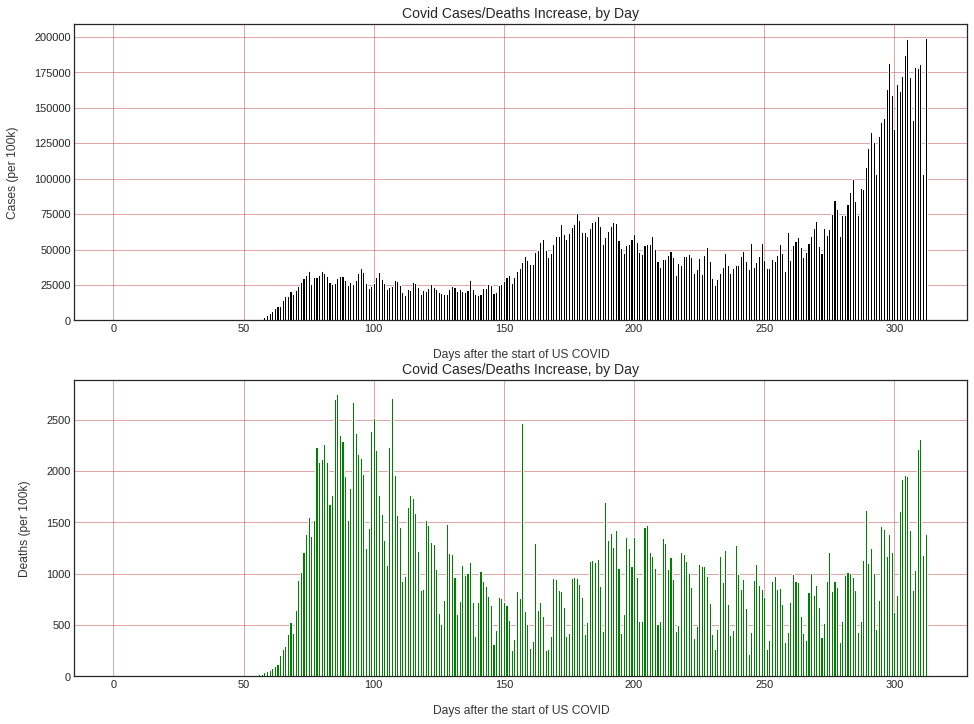

In [359]:
#EDA Basic Plotting for Cases by Date
date = us_df['days_since_start']
cases_inc = us_df['cases_increase']
deaths_inc = us_df['deaths_increase']

fig, ax = plt.subplots(2, figsize = (16,12))

ax[0].bar(date, cases_inc, color = 'black')
ax[1].bar(date, deaths_inc, color = 'green')

labels = ['Cases','Deaths']

for i in (range(0,2)):
    ax[i].set_title(f"Covid Cases/Deaths Increase, by Day", fontsize = 14)
    ax[i].grid(which = 'both', color='r', linestyle='-', linewidth=.5)
    ax[i].set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=12, color="#333533");
    ax[i].set_ylabel(f"{labels[i]} (per 100k)", labelpad=15, fontsize=12, color="#333533");

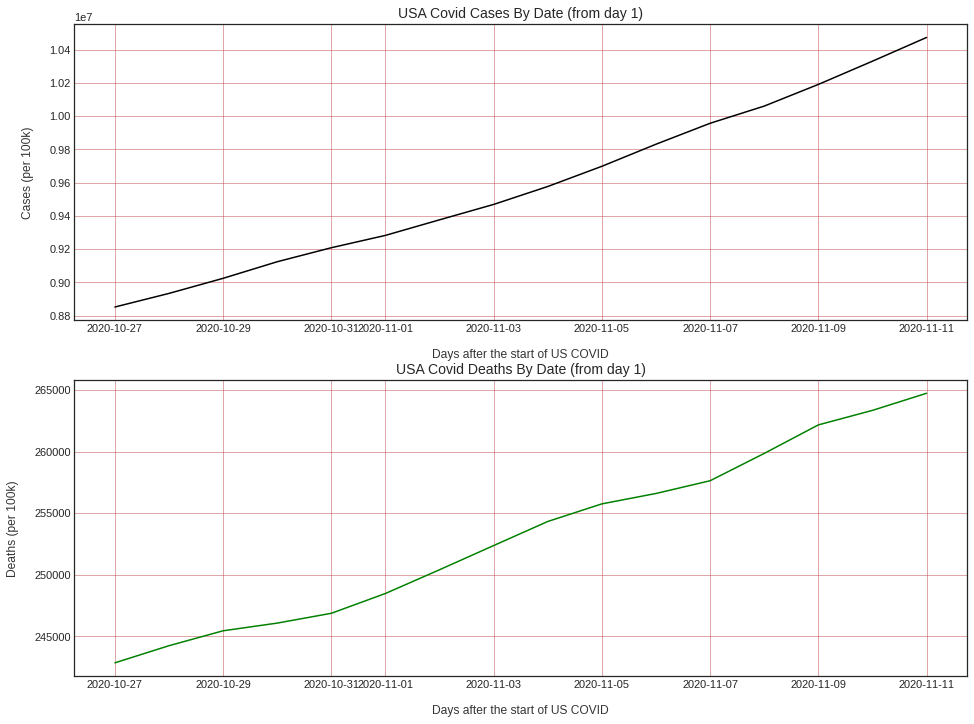

In [360]:
#EDA Basic Plotting for Cases by Date
date = us_df['date'][-32:-16]
cases = us_df['cases'][-32:-16]
deaths = us_df['deaths'][-16:]

fig, ax = plt.subplots(2, figsize = (16,12))

ax[0].plot(date, cases, color = 'black')
ax[1].plot(date, deaths, color = 'green')

labels = ['Cases','Deaths']

for i in (range(0,2)):
    ax[i].set_title(f"USA Covid {labels[i]} By Date (from day 1)", fontsize = 14)
    ax[i].grid(which = 'both', color='r', linestyle='-', linewidth=.5)
    ax[i].set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=12, color="#333533");
    ax[i].set_ylabel(f"{labels[i]} (per 100k)", labelpad=15, fontsize=12, color="#333533");

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


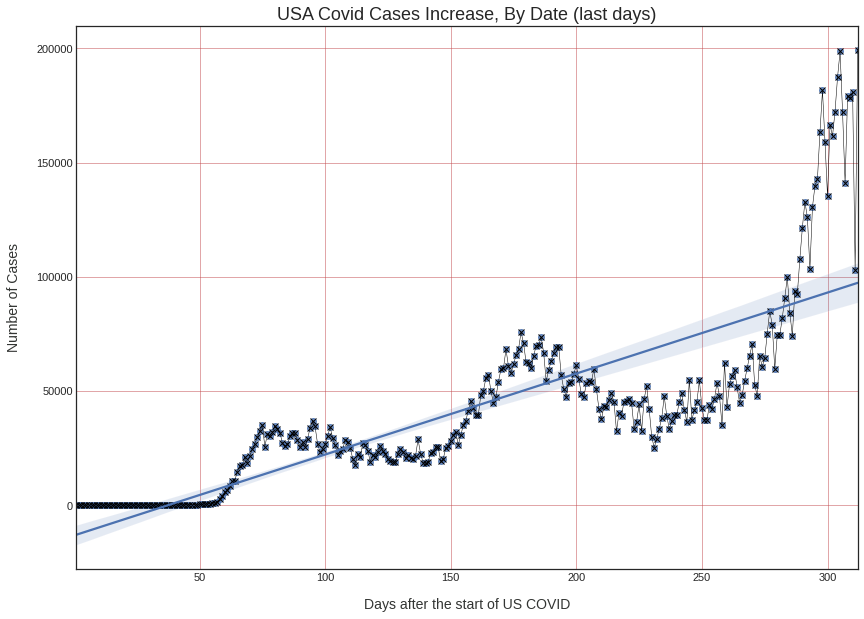

In [361]:
#EDA Basic Plotting for Cases by Date
date = us_df['days_since_start']
cases_inc = us_df['cases_increase']
deaths_inc = us_df['deaths_increase']

fig, ax = plt.subplots(figsize = (14,10))

ax.plot(date, cases_inc, '-x', color = 'black', linewidth = .5)
sns.regplot(date,cases_inc)

ax.set_title(f"USA Covid Cases Increase, By Date (last days)", fontsize = 18)
ax.grid(which = 'both', color='r', linestyle='-', linewidth=.5)
ax.set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=14, color="#333533");
ax.set_ylabel(f"Number of Cases", labelpad=15, fontsize=14, color="#333533");

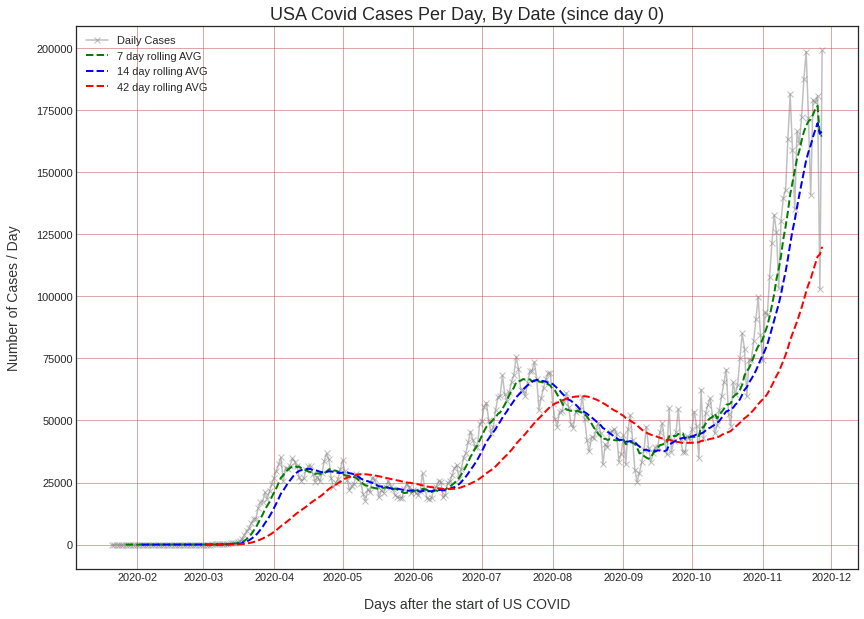

In [362]:
#EDA Basic Plotting for Cases by Date
n = 0

date = us_df['date'][-n:]
cases_inc = us_df['cases_increase'][-n:]
cases_7 = us_df['7_day_cases'][-n:]
cases_14 = us_df['14_day_cases'][-n:]
cases_42 = us_df['42_day_cases'][-n:]

fig, ax = plt.subplots(figsize = (14,10))

ax.plot(date, cases_inc, '-x', alpha = .5, color = 'gray', linewidth = 1.5, label = "Daily Cases")
ax.plot(date, cases_7, '--', color = 'green', linewidth = 2, label = "7 day rolling AVG")
ax.plot(date, cases_14, '--', color = 'blue', linewidth = 2, label = "14 day rolling AVG")
ax.plot(date, cases_42, '--', color = 'red', linewidth = 2, label = "42 day rolling AVG")
#sns.regplot(date,cases_inc)

ax.legend()
ax.set_title(f"USA Covid Cases Per Day, By Date (since day {n})", fontsize = 18)
ax.grid(which = 'both', color='r', linestyle='-', linewidth=.5)
ax.set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=14, color="#333533");
ax.set_ylabel(f"Number of Cases / Day", labelpad=15, fontsize=14, color="#333533");

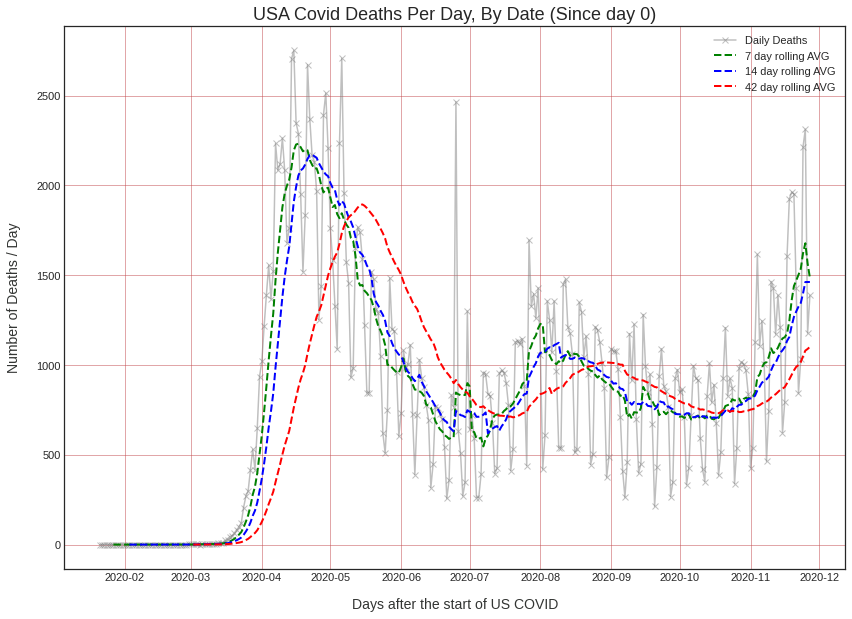

In [363]:
##ComparePlots
n = 0

date = us_df['date'][-n:]
deaths_inc = us_df['deaths_increase'][-n:]
deaths_7 = us_df['7_day_deaths'][-n:]
deaths_14 = us_df['14_day_deaths'][-n:]
deaths_42 = us_df['42_day_deaths'][-n:]

fig, ax = plt.subplots(figsize = (14,10))

ax.plot(date, deaths_inc, '-x', alpha = .5, color = 'gray', linewidth = 1.5, label = "Daily Deaths")
ax.plot(date, deaths_7, '--', color = 'green', linewidth = 2, label = "7 day rolling AVG")
ax.plot(date, deaths_14, '--', color = 'blue', linewidth = 2, label = "14 day rolling AVG")
ax.plot(date, deaths_42, '--', color = 'red', linewidth = 2, label = "42 day rolling AVG")
#sns.regplot(date,cases_inc)

ax.legend()
ax.set_title(f"USA Covid Deaths Per Day, By Date (Since day {n})", fontsize = 18)
ax.grid(which = 'both', color='r', linestyle='-', linewidth=.5)
ax.set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=14, color="#333533");
ax.set_ylabel(f"Number of Deaths / Day", labelpad=15, fontsize=14, color="#333533");

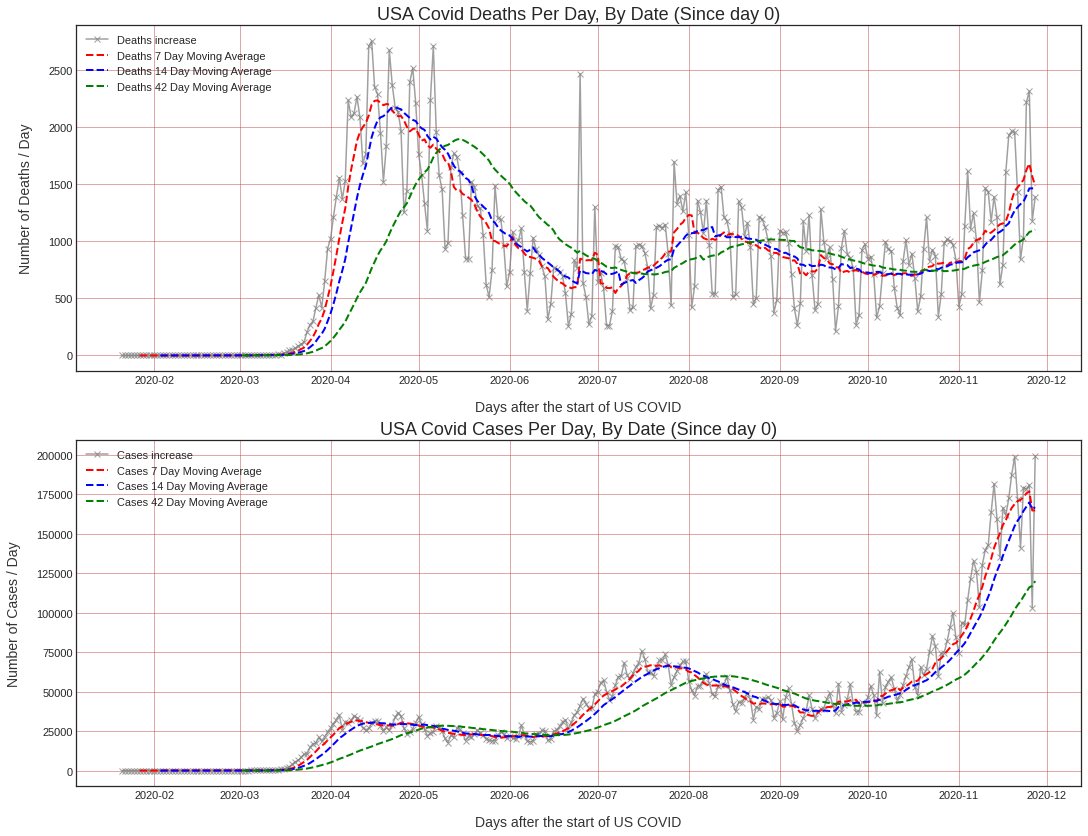

In [364]:
#EDA Basic Plotting for Cases by Date
n = 0

date = us_df['date'][-n:]

#Deaths Variables
deaths_inc = us_df['deaths_increase'][-n:]
deaths_7 = us_df['7_day_deaths'][-n:]
deaths_14 = us_df['14_day_deaths'][-n:]
deaths_42 = us_df['42_day_deaths'][-n:]

#Cases Variables
cases_inc = us_df['cases_increase'][-n:]
cases_7 = us_df['7_day_cases'][-n:]
cases_14 = us_df['14_day_cases'][-n:]
cases_42 = us_df['42_day_cases'][-n:]

#Let's Have the two plots together here:
fig, ax = plt.subplots(2, figsize = (18,14))

#Plot 1: Deaths

deaths_labels = [deaths_inc, deaths_7,deaths_14,deaths_42]
cases_labels = [cases_inc, cases_7,cases_14,cases_42]
labels = ['increase','7 Day Moving Average','14 Day Moving Average','42 Day Moving Average']
colors = ['grey','red', 'blue','green']
grf_marker = ['-x','--','--','--']
counters = [7,14,42]
multiplier = [1.5,2,2,2]

for i in range(0,4):
    ax[0].plot(date, deaths_labels[i], grf_marker[i],  alpha = .5 * multiplier[i], color = colors[i], linewidth = multiplier[i], label = "Deaths " + labels[i])
    ax[1].plot(date, cases_labels[i], grf_marker[i],  alpha = .5 * multiplier[i], color = colors[i], linewidth = multiplier[i], label = "Cases " + labels[i])

#Add the graphics
labels = ["Deaths","Cases"]

for i in range(0,2):
    ax[i].legend()
    ax[i].set_title(f"USA Covid {labels[i]} Per Day, By Date (Since day {n})", fontsize = 18)
    ax[i].grid(which = 'both', color='r', linestyle='-', linewidth=.5)
    ax[i].set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=14, color="#333533");
    ax[i].set_ylabel(f"Number of {labels[i]} / Day", labelpad=15, fontsize=14, color="#333533");

## What wave is this?
According to the deaths and cases graphs, this is probably the third wave. The first wave, according to each moving average, was around April/May (4-5), the second was in July/August (7-8), and this appears to be the third wave, (11-12). 

## Analysis
While the case numbers have exploded in recent weeks, the deaths have not gotten past their highs in March and April. This could be due to better treatment and therapeutics, as well as a better understanding of the disease. Deaths are also a lagging indicator, so we might see more deaths later in the year. Finally, it is possible that the lack of testing and underreporting for the virus earlier into the pandemic might indicate that there were a deceptively low number of cases reported- thus the death numbers were worse because there were so many people who were getting Covid.

Overall, we can perhaps be a bit more hopeful at present that the death rate was not similar to earlier in the pandemic, but it certainly remains to be seen. 

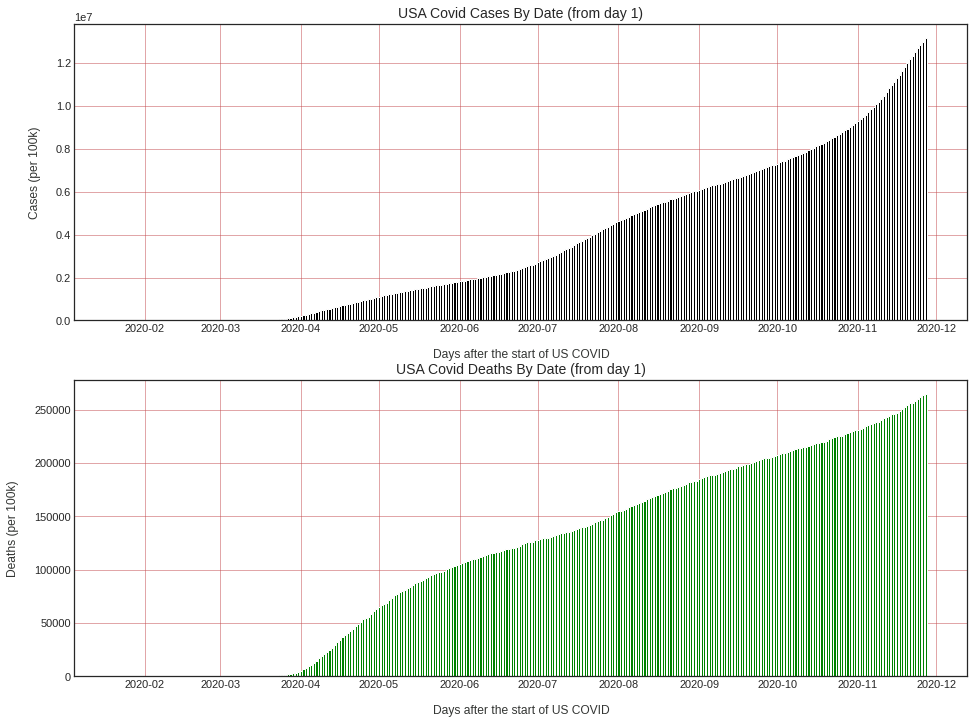

In [365]:
#EDA Basic Plotting for Cases by Date
date = us_df['date']
cases = us_df['cases']
deaths = us_df['deaths']

fig, ax = plt.subplots(2, figsize = (16,12))

ax[0].bar(date, cases, color = 'black')
ax[1].bar(date, deaths, color = 'green')

labels = ['Cases','Deaths']

for i in (range(0,2)):
    ax[i].set_title(f"USA Covid {labels[i]} By Date (from day 1)", fontsize = 14)
    ax[i].grid(which = 'both', color='r', linestyle='-', linewidth=.5)
    ax[i].set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=12, color="#333533");
    ax[i].set_ylabel(f"{labels[i]} (per 100k)", labelpad=15, fontsize=12, color="#333533");

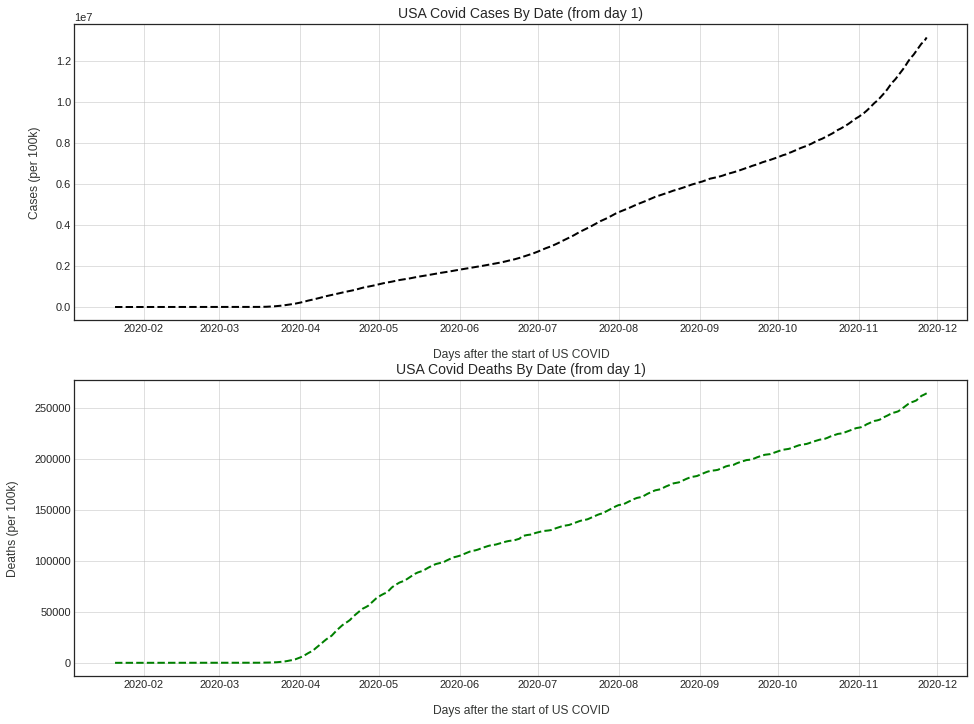

In [366]:
#EDA Basic Plotting for Cases by Date
date = us_df['date']
cases = us_df['cases']
deaths = us_df['deaths']

fig, ax = plt.subplots(2, figsize = (16,12))

ax[0].plot(date, cases, '--', color = 'black', linewidth = 2)
ax[1].plot(date, deaths, '--', color = 'green', linewidth = 2)

labels = ['Cases','Deaths']

for i in (range(0,2)):
    ax[i].set_title(f"USA Covid {labels[i]} By Date (from day 1)", fontsize = 14)
    ax[i].grid(which = 'both', color='silver', linestyle='-', linewidth=.5)
    ax[i].set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=12, color="#333533");
    ax[i].set_ylabel(f"{labels[i]} (per 100k)", labelpad=15, fontsize=12, color="#333533");

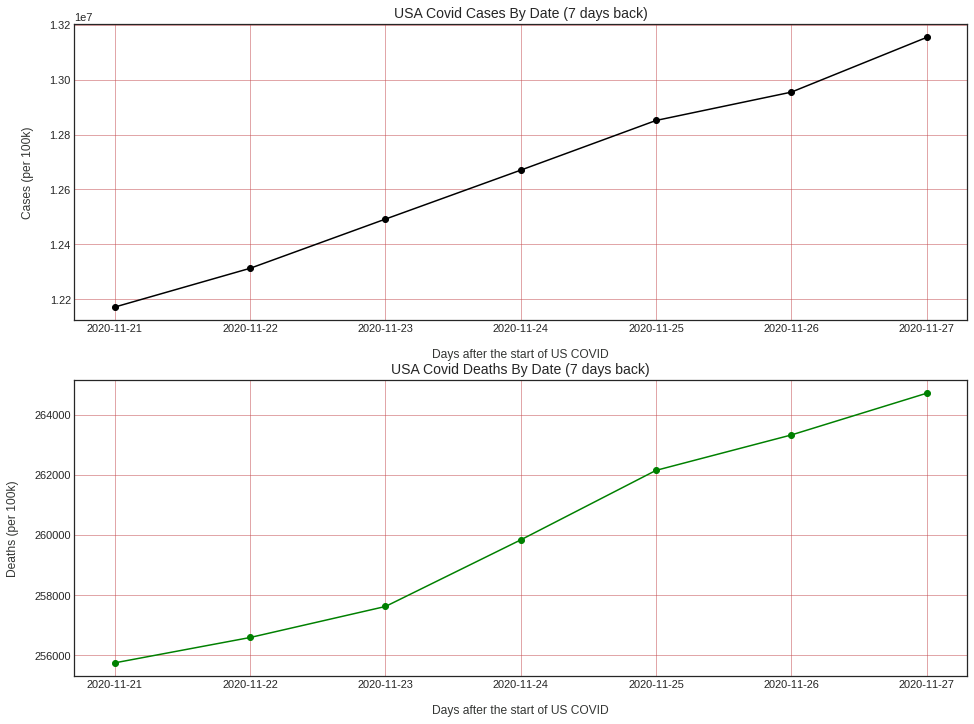

In [367]:
#How many days back?
n=-7

date = us_df['date'][n:]
cases = us_df['cases'][n:]
deaths = us_df['deaths'][n:]

fig, ax = plt.subplots(2, figsize = (16,12))

ax[0].plot(date, cases, '-o', color = 'black')
ax[1].plot(date, deaths, '-o', color = 'green')

labels = ['Cases','Deaths']

for i in (range(0,2)):
    ax[i].set_title(f"USA Covid {labels[i]} By Date ({abs(n)} days back)", fontsize = 14)
    ax[i].grid(which = 'both', color='r', linestyle='-', linewidth=.5)
    ax[i].set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=12, color="#333533");
    ax[i].set_ylabel(f"{labels[i]} (per 100k)", labelpad=15, fontsize=12, color="#333533");

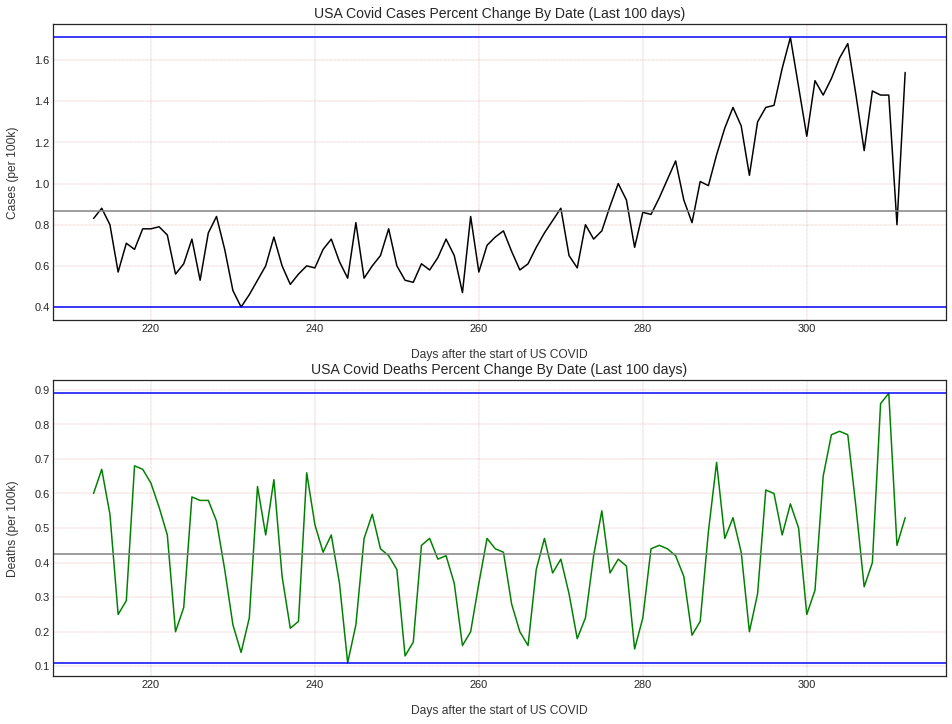

In [368]:
#EDA Basic Plotting for Cases by Date

n=-100 #How many days back?

date = us_df['days_since_start'][n:]
pct_chg_cases = us_df['cases_pct_inc'][n:]
pct_chg_deaths = us_df['deaths_pct_inc'][n:]

fig, ax = plt.subplots(2, figsize = (16,12))

labels = ['Cases','Deaths']
colors = ['black','green']
graph_list = [pct_chg_cases,pct_chg_deaths]

#Let's Graph It:
for i in (range(0,2)):
    ax[i].plot(date, graph_list[i], color = colors[i])
    ax[i].set_title(f"USA Covid {labels[i]} Percent Change By Date (Last {abs(n)} days)", fontsize = 14)
    ax[i].grid(which = 'both', color='r', linestyle='--', linewidth=.25)
    ax[i].set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=12, color="#333533");
    ax[i].set_ylabel(f"{labels[i]} (per 100k)", labelpad=15, fontsize=12, color="#333533");

#Using try statement just in case things don't work- doesn't work for stacked pairplot
    try:
          ax[i].axhline(y=min(graph_list[i]), xmin=0, xmax=1, color = 'blue')
          ax[i].axhline(y=statistics.mean(graph_list[i]), xmin=0, xmax=1,color = 'gray')
          ax[i].axhline(y=max(graph_list[i]), xmin=0, xmax=1, color = 'blue')
    except:
         break

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


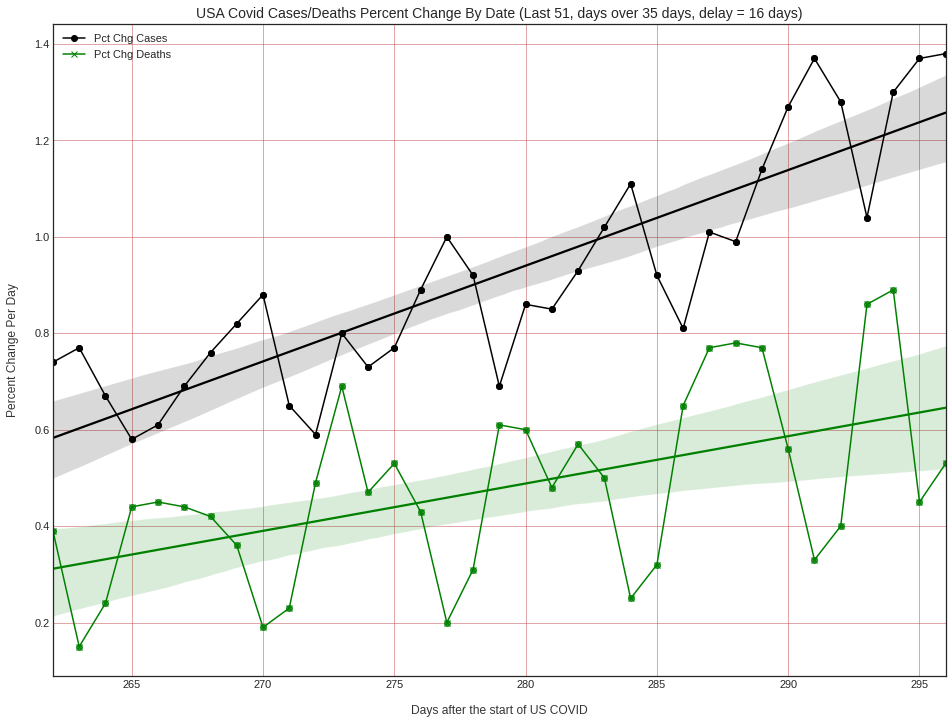

In [369]:
#EDA Basic Plotting for Cases by Date
n=-21 #How many days back?
start=-51
end=-16
delay = 16

date = us_df['days_since_start'][start:end]
pct_chg_cases = us_df['cases_pct_inc'][start:end]
pct_chg_deaths = us_df['deaths_pct_inc'][(start+delay):]

fig, ax = plt.subplots(figsize = (16,12))

ax.plot(date, pct_chg_cases, '-o', color = 'black', label = "Pct Chg Cases")
sns.regplot(date, pct_chg_cases, '--', color = 'black')
ax.plot(date, pct_chg_deaths, '-x', color = 'green', label = "Pct Chg Deaths")
sns.regplot(date, pct_chg_deaths, '--', color = 'green')

labels = ['Cases','Deaths']
ax.legend()
ax.set_title(f"USA Covid Cases/Deaths Percent Change By Date (Last {abs(start)}, days over {abs(start) - delay} days, delay = {delay} days)", fontsize = 14)
ax.grid(which = 'both', color='r', linestyle='-', linewidth=.5)
ax.set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Percent Change Per Day", labelpad=15, fontsize=12, color="#333533");

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


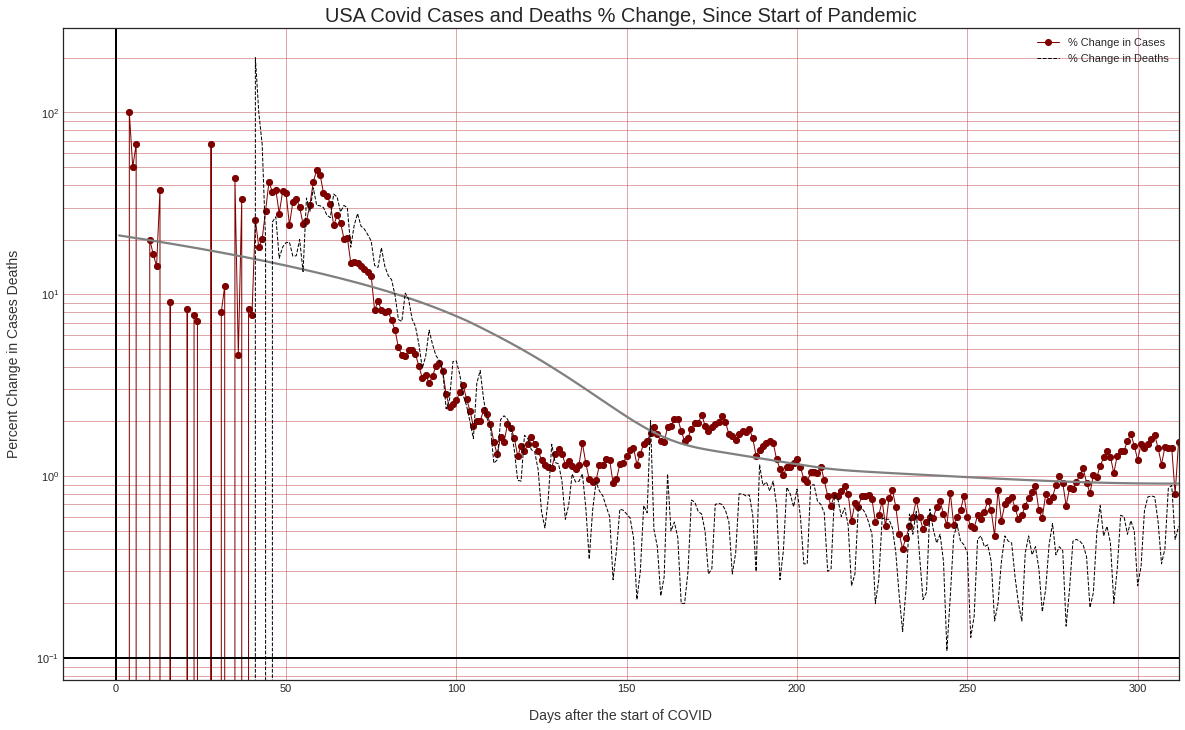

In [370]:
#Date by Rate of Change
date = us_df['days_since_start']
pct_chg_cases = us_df['cases_pct_inc']
pct_chg_deaths = us_df['deaths_pct_inc']

fig, ax = plt.subplots(figsize = (20,12), sharex = True)

ax.plot(date, pct_chg_cases, '-o', color = 'maroon', linewidth = 1, label = '% Change in Cases')
sns.regplot(date, pct_chg_cases,  color = 'gray', lowess=True)

ax.plot(date, pct_chg_deaths, '--', color = 'black', linewidth = 1, label = '% Change in Deaths')
#sns.regplot(date, pct_chg_deaths, color = 'orange')

#Graphics Stuff
ax.set_title("USA Covid Cases and Deaths % Change, Since Start of Pandemic", fontsize = 20)
plt.yscale("log")
ax.legend()
ax.grid(which = 'both', color='r', linestyle='-', linewidth=.5)
ax.axhline(y=10**-1, color = "black",linewidth=2)
ax.axvline(x=0, color = "black",linewidth=2)
ax.set_xlabel("Days after the start of COVID", labelpad=15, fontsize=14, color="#333533");
ax.set_ylabel("Percent Change in Cases Deaths", labelpad=15, fontsize=14, color="#333533");

In [371]:
#Save the new us csv as a file
us_df.to_csv("nyt_cleaned_us_covid.csv")

## Basic Scikit Learn Linear Regression Model to Predict Future Outcome
How many deaths should we expect?



In [372]:
#Let's look at the data again to see which variables might be helpful to look at
us_df.head()

,date,days_since_start,cases,cases_increase,7_day_cases,14_day_cases,42_day_cases,cases_pct_inc,deaths,deaths_increase,deaths_pct_inc,7_day_deaths,42_day_deaths,14_day_deaths
0,2020-01-21,1,1,0,NaN,NaN,NaN,0.0,0,0,0.0,NaN,NaN,NaN
1,2020-01-22,2,1,0,NaN,NaN,NaN,0.0,0,0,0.0,NaN,NaN,NaN
2,2020-01-23,3,1,0,NaN,NaN,NaN,0.0,0,0,0.0,NaN,NaN,NaN
3,2020-01-24,4,2,1,NaN,NaN,NaN,100.0,0,0,0.0,NaN,NaN,NaN
4,2020-01-25,5,3,1,NaN,NaN,NaN,50.0,0,0,0.0,NaN,NaN,NaN


In [373]:
#Let's try with days since start, the number of cases and cases increase. Cases and cases increase will lag behind the deaths.
X = us_df[['days_since_start']]
y = us_df['deaths']

In [374]:
#Break up the data with train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [375]:
#Scikit Learn Model- Linear Regression 
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [376]:
#What are the coefficients that the model is using?
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
days_since_start,942.412913


In [377]:
#What's the prediction?
y_pred = regressor.predict(X_test)

In [378]:
y_pred

array([ 3.00554223e+04,  1.80841488e+05,  1.45972211e+05,  1.57281166e+05,
        7.05791775e+04,  1.94035269e+05,  9.41395003e+04,  7.81184808e+04,
        3.85371385e+04,  2.13825940e+05, -6.69868133e+03,  2.04401811e+05,
        1.78040544e+04,  1.93092856e+05,  1.10160520e+05,  1.68590120e+05,
        2.01574572e+05,  2.48695218e+05, -1.04683330e+04,  2.02516985e+05,
        2.03459398e+05,  2.15737061e+04,  1.26181539e+05, -2.46045267e+04,
        1.92150443e+05, -1.70652234e+04,  6.39822871e+04, -1.14107459e+04,
        2.06312931e+04, -1.98924621e+04,  1.12987759e+05,  6.02126355e+04,
        1.20527062e+05,  1.86495966e+05,  8.37729583e+04,  1.90265617e+05,
        1.56338753e+05,  3.09978352e+04,  2.10056289e+05,  1.25239126e+05,
        2.00632160e+05,  5.55005709e+04,  8.56577841e+04,  2.08171463e+05,
        2.24192482e+05,  2.44009448e+04,  9.60243262e+04,  1.74244598e+05,
        1.70474946e+05, -1.51803975e+04,  2.12883527e+05, -2.36621138e+04,
        1.02621217e+05,  

In [379]:
#Linear Regression
df_lin = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_lin.insert(0,"Days Since Start", us_df['days_since_start'])
df_lin = df_lin.sort_values(by="Days Since Start")

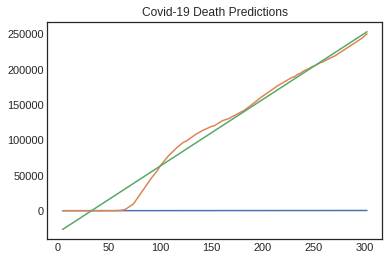

In [380]:
#Let's see what the predictions would be
plt.title("Covid-19 Death Predictions")
plt.plot(df_lin)

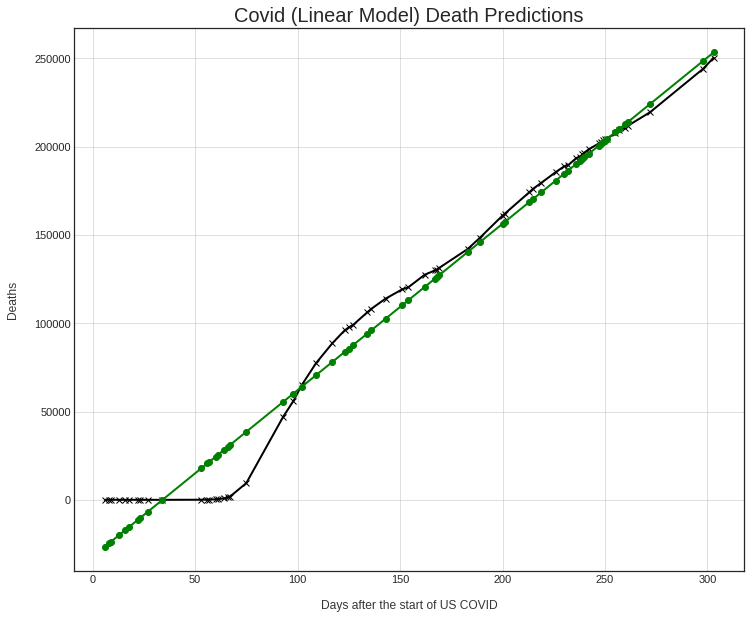

In [381]:
#EDA Basic Plotting for Cases by Date
date = df_lin['Days Since Start']
cases = df_lin['Actual']
deaths = df_lin['Predicted']

fig, ax = plt.subplots(1, figsize = (12,10))

ax.plot(date, cases, '-x', color = 'black', linewidth = 2)
ax.plot(date, deaths, '-o', color = 'green', linewidth = 2)

ax.set_title(f"Covid (Linear Model) Death Predictions", fontsize = 20)
ax.grid(which = 'both', color='silver', linestyle='-', linewidth=.5)
ax.set_xlabel("Days after the start of US COVID", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Deaths", labelpad=15, fontsize=12, color="#333533");

The Deaths Curve surprisingly standardizes pretty well to a simple line so far. It remains to be seen if this would continue.

In [382]:
#How did the model do?
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 9442.821528916138
Mean Squared Error: 164691347.27784994
Root Mean Squared Error: 12833.21266393766


In [383]:
#What day is the data recorded to?
us_df.tail(1)

,date,days_since_start,cases,cases_increase,7_day_cases,14_day_cases,42_day_cases,cases_pct_inc,deaths,deaths_increase,deaths_pct_inc,7_day_deaths,42_day_deaths,14_day_deaths
311,2020-11-27,312,13153428,199104,164754.142857,166732.428571,119993.380952,1.54,264724,1388,0.53,1485.571429,1101.142857,1462.428571


In [384]:
#Let's try to see how many days are left before the end of the year, so we can do the calculations
from datetime import date

last_day = us_df['date'].iloc[-1]
end_of_year = date(2021, 1, 1)

days_left = (end_of_year - last_day).days

In [385]:
#How many days ARE left?
days_left

35

In [386]:
#How many days do we have in there?
len(us_df['date'])

312

## Deaths Prediction Before Jan 1
So what does the Linear Model Predict for Deaths Before January 1?

In [387]:
#Prediction for Jan 1
eoy_prediction = regressor.predict(np.array(len(us_df['date'])+days_left).reshape(1, 1))
print(f"{eoy_prediction[0]} Deaths")

294873.45079874253 Deaths


## So the linear model is estimating about 295k deaths:
About 294873 deaths before the end of the year, which is pretty frightening. This estimate means...

In [388]:
#So the eoy average would be the prediction divided by days left 
eoy_average = (us_df['deaths'].iloc[-1] - eoy_prediction[0]) / days_left

print(f"{abs(us_df['deaths'].iloc[-1] - eoy_prediction[0])} deaths")
print(f"{abs(eoy_average)} per day.")


30149.45079874253 deaths
861.4128799640723 per day.


In [389]:
#Add one column of prediction for days left before EOY
death_est = []
for i in range(len(us_df['date']),400):
    death_est.append(regressor.predict(np.array([i]).reshape(1, 1)))

# Conclusion: Death Estimates Before End of Year
Last, let's plot the estimated number of deaths...

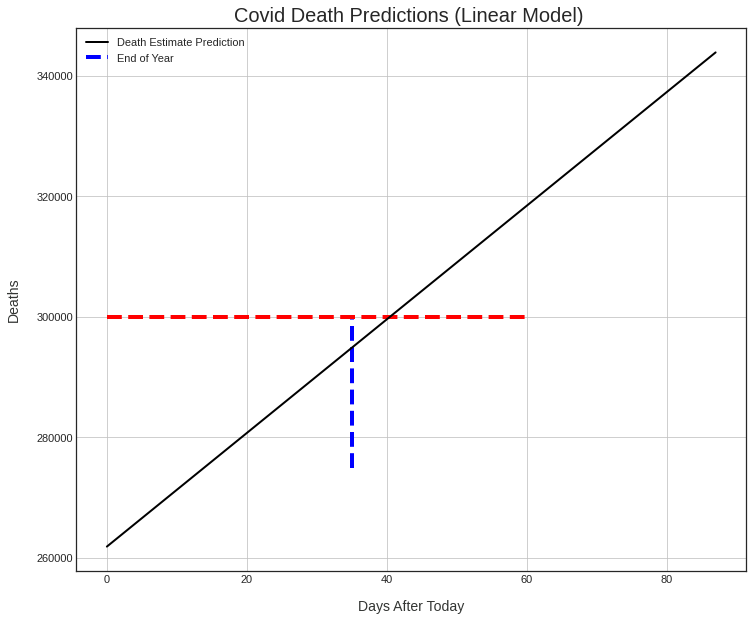

In [390]:
#Death Estimates until end of year (linear)
date = df_lin['Days Since Start']
cases = df_lin['Actual']
deaths = df_lin['Predicted']

fig, ax = plt.subplots(1, figsize = (12,10))

ax.plot(death_est, '-', color = 'black', linewidth = 2, label = 'Death Estimate Prediction')

ax.set_title(f"Covid Death Predictions (Linear Model) ", fontsize = 20)
ax.grid(which = 'both', color='silver', linestyle='-', linewidth=.75)
ax.vlines(x=days_left, ymin = 275000, ymax = 300000, linestyle='--', color = 'blue', linewidth=4, label='End of Year')
ax.hlines(y=300000, xmin = 0, xmax = 60, linestyle='--', linewidth=4, color = 'red')
ax.set_xlabel("Days After Today", labelpad=15, fontsize=14, color="#333533");
ax.set_ylabel(f"Deaths", labelpad=15, fontsize=14, color="#333533");
ax.legend()

# Deaths- Conclusion
So, if we simply treat the number of days since start as being the lone independent variable, we would estimate there being about 295k deaths on Jan 1.

The linear model also shows that in about +6 days, we would expect to hit the 300,000 deaths mark, according to what we have right now.

In [391]:
us_df.to_csv('linear_model')